# Data Processing

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import torch
from torch import nn
from torch import optim
import torchvision
from torchvision import transforms
from torch.utils.data import random_split, DataLoader
from sklearn.preprocessing import StandardScaler

In [ ]:
# RNG
torch.manual_seed(42)

Because of instrumental errors in 2011 from an event that affected ACE, certain data is tainted. This following cell fixes this problem by appropriately filtering the data.

In [ ]:
import scipy.io
from datetime import datetime, timedelta
import pandas as pd

# Load the IDL .save file
data = scipy.io.readsav('ACE_SWICS_1998_2022_COratio_combined.save')

# Explore the data structure to understand how data is stored
#print(data.keys())

ace_swics = pd.DataFrame({
    'fyear_ace': data['fyear_ace'],
    'o7too6_t': data['o7too6_t'],
    'c6toc5_t': data['c6toc5_t'],
    'h_v': data['h_v']
})

ace_swics['fyear_ace'] = ace_swics['fyear_ace'].astype(np.float64, copy=False)
ace_swics['o7too6_t'] = ace_swics['o7too6_t'].astype(np.float32, copy=False)
ace_swics['c6toc5_t'] = ace_swics['c6toc5_t'].astype(np.float32, copy=False)
ace_swics['h_v'] = ace_swics['h_v'].astype(np.float32, copy=False)

ace_swics = ace_swics[(ace_swics['o7too6_t'] < 0.145) & (ace_swics['o7too6_t'] > 0.052272) & (ace_swics['c6toc5_t'] <= 1.425) & (ace_swics['c6toc5_t'] >= 0.1104)]

def fractional_year_to_datetime(fractional_year):
    """Convert a fractional year to a datetime object."""
    # Separate the integer year from the fractional part
    year = int(fractional_year)
    fractional_part = fractional_year - year

    # Calculate the number of days corresponding to the fractional part
    # Consider if it's a leap year for precise calculations
    base = datetime(year, 1, 1)
    if (year % 4 == 0 and year % 100 != 0) or (year % 400 == 0):
        # Leap year: 366 days
        days_in_year = 366
    else:
        # Non-leap year: 365 days
        days_in_year = 365

    # Compute the exact date by adding the number of whole days represented
    # by the fractional part.
    delta = timedelta(days=fractional_part * days_in_year)
    return base + delta

ace_swics['fyear_ace'] = ace_swics['fyear_ace'].apply(fractional_year_to_datetime)
ace_swics.rename(columns={'fyear_ace':'Datetime'}, inplace=True)

ace_swics.set_index('Datetime', inplace=True)

ace_swics.dropna(inplace=True)
ace_swics = ace_swics.resample('D').mean()

#ace_swics

In [ ]:
mag_dataframe=pd.read_csv("ACE_MAG_FULL.txt", header=37, sep="\s+")
mag_dataframe['md'] = pd.to_datetime(mag_dataframe['day'], format='%j').dt.strftime('%m-%d')
mag_dataframe['time'] = pd.to_datetime(mag_dataframe['hr'], format='%H').dt.strftime('%H:%M:%S')
mag_dataframe['Datetime'] = pd.to_datetime(mag_dataframe['year'].astype(str) + '-' + mag_dataframe.md + " " + mag_dataframe.time)
mag_dataframe = mag_dataframe.replace(-999.900, np.nan)
mag_dataframe.dropna(subset=['Br'], inplace=True)
mag_dataframe['|Br|r^2'] = abs(mag_dataframe['Br'])
mag_dataframe.index = mag_dataframe.Datetime
mag_dataframe = mag_dataframe.drop(columns=['year','day','hr','min','sec','fp_year','fp_doy','Datetime','md','time'])
mag_dataframe = mag_dataframe.resample('D').mean()

#mag_dataframe

In [ ]:
ace = mag_dataframe[mag_dataframe.index.isin(ace_swics.index)]
#ace

In [ ]:
hcs = pd.read_csv("ACE_HCS.csv")

hcs["Datetime"] = hcs["fyear"].apply(fractional_year_to_datetime)
hcs["Polar Angle"] = (90 - np.abs(hcs["distance to HCS in degree"])) * np.pi / 180

hcs["Non-Streamer Area"] = 4 * np.pi * (1 - np.cos(hcs["Polar Angle"]))

hcs.index = hcs.Datetime
hcs.drop(columns=["fyear", "Datetime"], inplace=True)

hcs = hcs.resample('D').mean()

#hcs

In [ ]:
ace = ace.join(hcs, how='inner')
#ace

In [ ]:
ace["TOMF"] = ace["|Br|r^2"] * ace["Non-Streamer Area"]
#ace

In [ ]:
ace = ace.join(ace_swics, how='inner')
#ace

In [ ]:
ace.drop(columns=["ACEepoch", "SCclock", "Delta", "Lambda", "fraction_good", "N_vectors", "Quality", "pos_gse_x", "pos_gse_y", "pos_gse_z", "pos_gsm_x", "pos_gsm_y", "pos_gsm_z"], inplace=True)
ace.columns

Index(['Br', 'Bt', 'Bn', 'Bmag', 'Bgse_x', 'Bgse_y', 'Bgse_z', 'Bgsm_x',
       'Bgsm_y', 'Bgsm_z', 'dBrms', 'sigma_B', '|Br|r^2',
       'distance to HCS in degree', 'Polar Angle', 'Non-Streamer Area', 'TOMF',
       'o7too6_t', 'c6toc5_t', 'h_v'],
      dtype='object')

In [ ]:
#data leakage columns used to calculate TOMF must be removed
ace.drop(columns=["Br", "|Br|r^2", 'distance to HCS in degree', 'Polar Angle', 'Non-Streamer Area'], inplace=True)
ace.columns

Index(['Bt', 'Bn', 'Bmag', 'Bgse_x', 'Bgse_y', 'Bgse_z', 'Bgsm_x', 'Bgsm_y',
       'Bgsm_z', 'dBrms', 'sigma_B', 'TOMF', 'o7too6_t', 'c6toc5_t', 'h_v'],
      dtype='object')

In [ ]:
!python -m pip install hapiclient

In [ ]:
from dateutil.relativedelta import relativedelta
from hapiclient import hapi, hapitime2datetime

server     = 'https://cdaweb.gsfc.nasa.gov/hapi'
dataset    = 'OMNI2_H0_MRG1HR'
# Notes:
# 1. Use parameters='' to request all parameters from OMNI2_H0_MRG1HR.
# 2. Multiple parameters can be requested using a comma-separated
#    list, e.g., parameters='Rot1800,IMF1800'
parameters = 'R1800'
start      = '1970-01-01T00:00:00Z' # min 1963-01-01T00:00:00Z
stop       = '2023-05-19T00:00:00Z' # max 2024-06-05T14:00:00Z

ssn_data2, ssn_meta = hapi(server, dataset, parameters, start, stop)

In [ ]:
ssnData = pd.DataFrame(ssn_data2)

ssnData = ssnData.replace(-1, np.nan)

ssnData["Datetime"] = hapitime2datetime(ssn_data2["Time"])
ssnData['Datetime'] = ssnData['Datetime'].apply(lambda t: t.replace(tzinfo=None))
ssnData.rename(columns={"R1800":"ssn"}, inplace = True)
ssn_data1 = ssnData
print(ssn_data1.iloc[78])

ssnData.index = ssnData["Datetime"]

ssnData = ssnData.drop(columns=["Time", "Datetime"])

ssnData = ssnData.resample("D").mean()

#ssnData

/usr/local/lib/python3.11/dist-packages/hapiclient/hapitime.py:284: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  Time = pandas.to_datetime(Time, infer_datetime_format=True).tz_convert(tzinfo).to_pydatetime()


Time        b'1970-01-04T06:30:00.000Z'
ssn                                  98
Datetime            1970-01-04 06:30:00
Name: 78, dtype: object


In [ ]:
ace = ace.join(ssnData, how='inner')
#ace

In [ ]:
ace=ace.dropna()
#ace

# Split Data for Testing

In [ ]:
ace = ace.reset_index()
ace['Year'] = ace['Datetime'].dt.year
ace['Month'] = ace['Datetime'].dt.month
ace['Day'] = ace['Datetime'].dt.day

feature_cols = ['Bt', 'Bn', 'Bmag', 'Bgse_x', 'Bgse_y', 'Bgse_z',
                'dBrms', 'sigma_B', 'o7too6_t', 'c6toc5_t', 'h_v',
                'Year', 'Month', 'Day', 'ssn']

X = ace[feature_cols]
y = ace['TOMF']

scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X)
X = pd.DataFrame(X_scaled, columns=feature_cols)
X.index = ace['Datetime']

scaler_y = StandardScaler()
y = scaler_y.fit_transform(y.values.reshape(-1, 1)).flatten()

In [ ]:
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset

# Split data into training and test sets (80% train, 20% test+val)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

# Further split the temporary set into validation and test sets (10% each)
#X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, shuffle=False)

# Convert training, validation, and test data to PyTorch tensors
# Use the values attribute of the DataFrame to get the underlying NumPy array
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)
#X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
#y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Create TensorDatasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
#test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)  # Shuffle for training
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)     # No need to shuffle
#test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Machine Learning Models

## Trees

In [ ]:
from sklearn.metrics import mean_squared_error

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score, mean_squared_error

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingRegressor, GradientBoostingClassifier

### CART

In [ ]:
cart = DecisionTreeRegressor(max_depth=4, random_state=42)
cart.fit(X_train, y_train)

y_pred_cart = cart.predict(X_val)
mse_cart = mean_squared_error(y_val, y_pred_cart)
print(f"Mean Squared Error: {mse_cart}")

Mean Squared Error: 0.4312737523552968


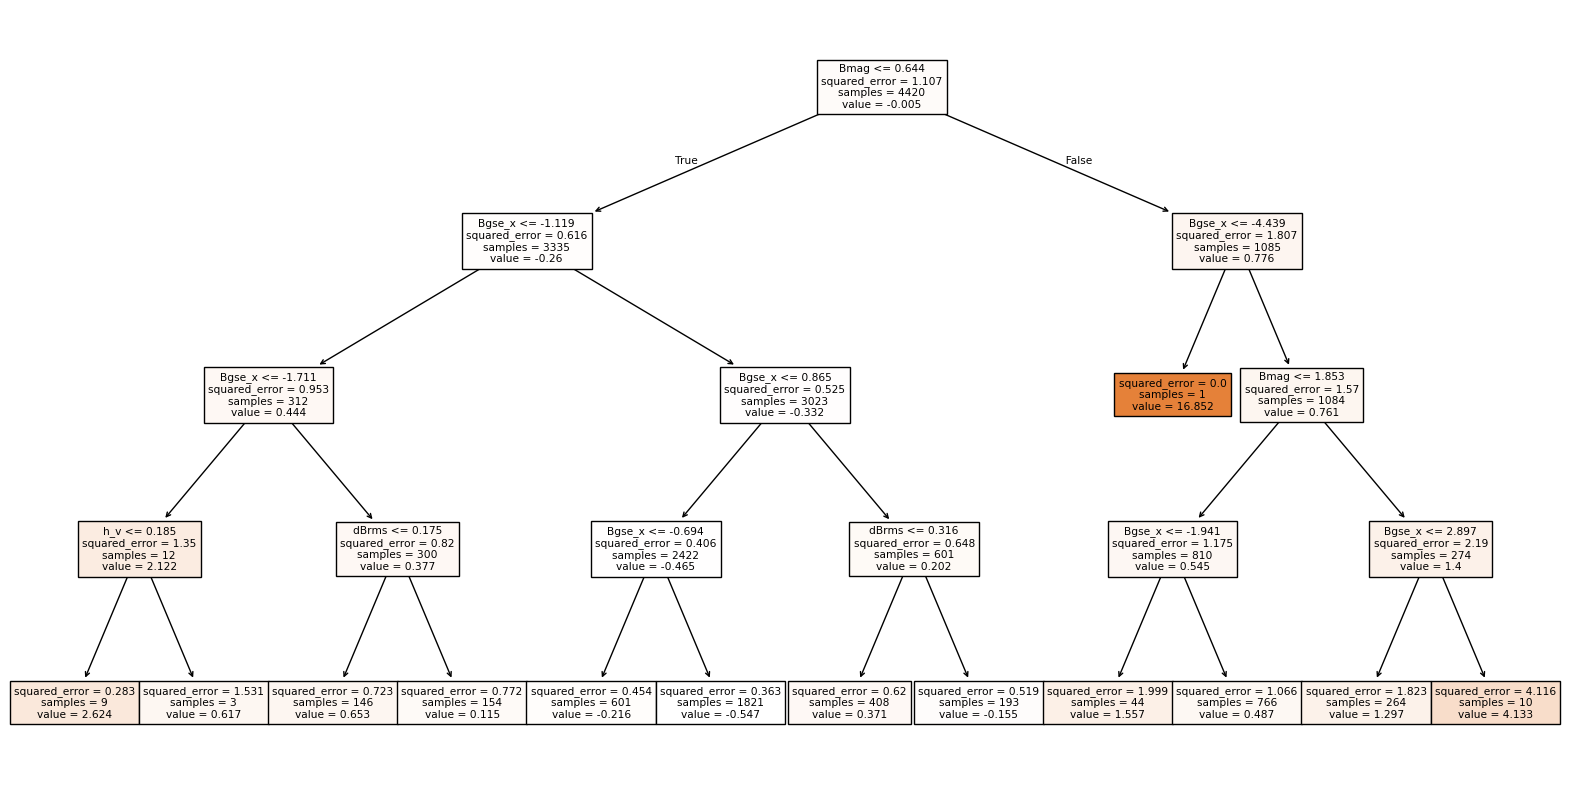

In [ ]:
plt.figure(figsize=(20,10))
tree.plot_tree(cart, feature_names=feature_cols, filled=True)
plt.show()

### Random Forest

In [ ]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_val)
mse_rf = mean_squared_error(y_val, y_pred_rf)
print(f"Mean Squared Error: {mse_rf}")

Mean Squared Error: 0.2713529954461036


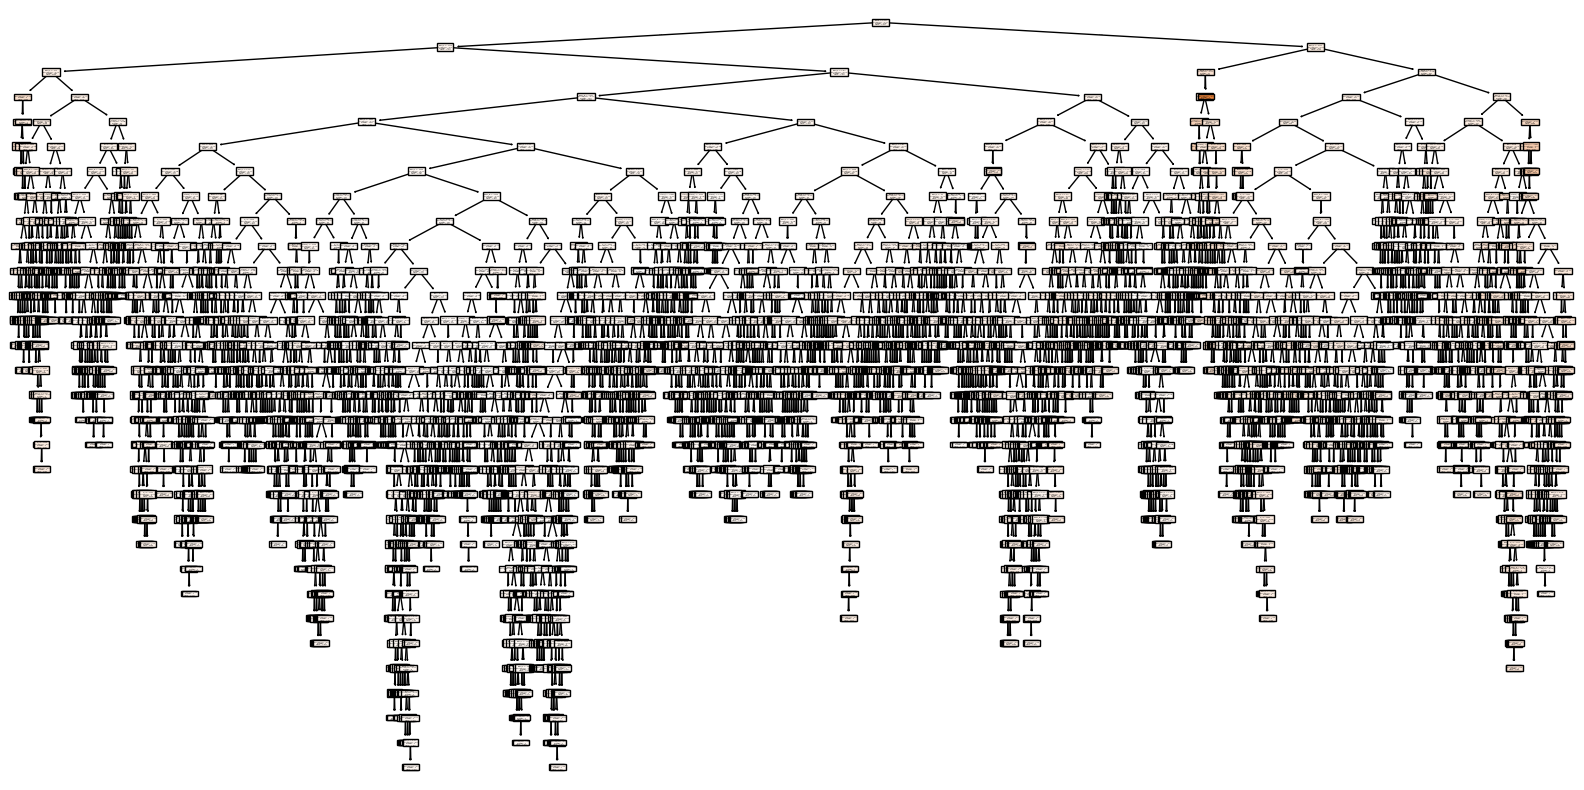

In [ ]:
plt.figure(figsize=(20,10))
tree.plot_tree(rf.estimators_[0], feature_names=feature_cols, filled=True)
plt.show()

### Boosting

In [ ]:
boost = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
boost.fit(X_train, y_train)

y_pred_boost = boost.predict(X_val)
mse_boost = mean_squared_error(y_val, y_pred_boost)
print(f"Mean Squared Error: {mse_boost}")

Mean Squared Error: 0.24596814992545463


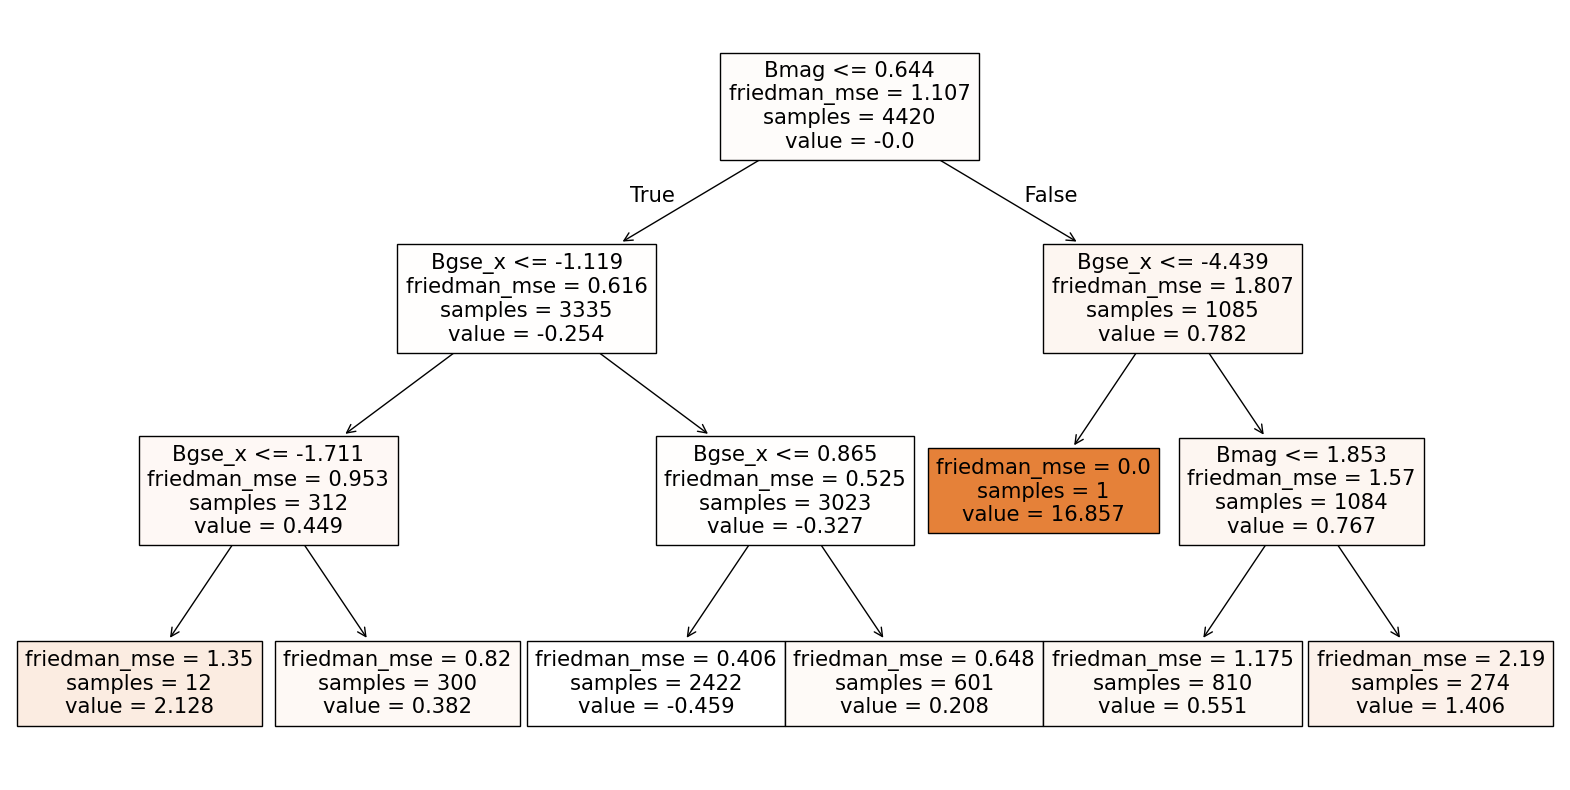

In [ ]:
plt.figure(figsize=(20,10))
tree.plot_tree(boost.estimators_[0][0], feature_names=feature_cols, filled=True)
plt.show()

### Tree Error Analysis

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# CART model evaluation
y_pred_cart = cart.predict(X_val)
mse_cart = mean_squared_error(y_val, y_pred_cart)
rmse_cart = np.sqrt(mse_cart)  # Calculate RMSE
mae_cart = mean_absolute_error(y_val, y_pred_cart)
r2_cart = r2_score(y_val, y_pred_cart)

# Random Forest model evaluation
y_pred_rf = rf.predict(X_val)
mse_rf = mean_squared_error(y_val, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)  # Calculate RMSE
mae_rf = mean_absolute_error(y_val, y_pred_rf)
r2_rf = r2_score(y_val, y_pred_rf)

#Boosting model evaluation
y_pred_boost = boost.predict(X_val)
mse_boost = mean_squared_error(y_val, y_pred_boost)
rmse_boost = np.sqrt(mse_boost)  # Calculate RMSE
mae_boost = mean_absolute_error(y_val, y_pred_boost)
r2_boost = r2_score(y_val, y_pred_boost)

In [ ]:
# Create a dictionary to store the evaluation metrics
error_analysis = {
    'Model': ['CART', 'Random Forest', 'Boosting'],
    'MSE': [mse_cart, mse_rf, mse_boost],
    'RMSE': [rmse_cart, rmse_rf, rmse_boost],
    'MAE': [mae_cart, mae_rf, mae_boost],
    'R^2': [r2_cart, r2_rf, r2_boost]
}

# Create the pandas DataFrame
df_error_analysis = pd.DataFrame(error_analysis)
df_error_analysis

,Model,MSE,RMSE,MAE,R^2
0,CART,0.431274,0.656714,0.495202,0.245697
1,Random Forest,0.271353,0.520916,0.390083,0.525400
2,Boosting,0.245968,0.495952,0.379697,0.569799


In [ ]:
from sklearn.model_selection import cross_val_score, KFold

# Define the number of folds for cross-validation
n_splits = 5

# Define the cross-validation strategy (KFold)
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Perform cross-validation for each model
models = {
    'CART': cart,
    'Random Forest': rf,
    'Boosting': boost
}
results = {}

for model_name, model in models.items():

    # Calculate cross-validation scores (e.g., R-squared)
    scores = cross_val_score(model, X, y, cv=kf, scoring='neg_mean_squared_error')

    results[model_name] = scores
    print(f"Cross-validation results for {model_name}:")
    print(f"MSE scores: {-scores}")  # Multiply by -1 to convert from negative to positive values
    print(f"Average MSE: {-scores.mean()}")
    print(f"Standard deviation of MSE: {scores.std()}\n")



Cross-validation results for CART:
MSE scores: [0.63956444 0.61605561 0.63530257 0.65392376 0.93910485]
Average MSE: 0.6967902457459709
Standard deviation of MSE: 0.12176001752160161

Cross-validation results for Random Forest:
MSE scores: [0.45925746 0.43843581 0.41069065 0.46349515 0.67342589]
Average MSE: 0.4890609929508708
Standard deviation of MSE: 0.09406072128037431

Cross-validation results for Boosting:
MSE scores: [0.43895344 0.43752415 0.3856072  0.42677725 0.65720744]
Average MSE: 0.4692138965168553
Standard deviation of MSE: 0.0959713037746402



## Ridge Regression

In [ ]:
from sklearn.linear_model import RidgeCV

alphas = np.logspace(-3, 3, 50)

ridge_cv = RidgeCV(alphas=alphas, store_cv_values=True)
ridge_cv.fit(X_train, y_train)

y_pred_ridge = ridge_cv.predict(X_val)
mse_ridge = mean_squared_error(y_val, y_pred_ridge)

print(f"Mean Squared Error: {mse_ridge}")
print(f"Best alpha: {ridge_cv.alpha_}")

Mean Squared Error: 0.4686564755925886
Best alpha: 33.9322177189533


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_ridge.py:2385: FutureWarning: 'store_cv_values' is deprecated in version 1.5 and will be removed in 1.7. Use 'store_cv_results' instead.
  warnings.warn(


# Building a Neural Network/Model Training

In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=100, patience=10):
    """
      model (torch.nn.Module): The neural network
      train_loader (torch.utils.data.DataLoader): Training data
      val_loader (torch.utils.data.DataLoader): Validation data
      criterion (torch.nn Loss function): The loss function
      optimizer (torch.optim): The optimizer used to make gradient steps
      num_epochs (int): The number of training epochs to perform
      patience (int): Number of epochs to use for early stopping. If 0, early stopping is not used.
    """

    # intiate two lists way to keep track of training and validation losses
    validation_losses = []
    training_losses = []

    min_validation_loss = float('inf')
    patience_counter = 0

    # for each epoch...
    for epoch in range(num_epochs):
        # initialize the training loss as zero
        train_loss = 0
        # set the model to train mode
        model.train()

        for batch_X, batch_y in train_loader:
            # new iteration so we set gradients to zero
            optimizer.zero_grad()

            # get outputs from the model (forward pass)
            outputs = model(batch_X)

            # get the loss using the outputs and the truth
            loss = criterion(outputs, batch_y)

            # compute gradients of the loss with respect to model parameters (backward pass)
            loss.backward()

            # take a step with optimizer to update model parameters using computed gradients
            optimizer.step()

            # add to the epoch's runnning training loss
            train_loss += loss.item()


        # get the mean training loss
        train_loss /= len(train_loader)

        # append training loss observation to train lost list
        training_losses.append(train_loss)


        # we want to evaluate model losses on validation set so we set model
        # to eval mode here
        model.eval()

        # initialize the validation loss as zero
        val_loss = 0
        # we also don't want to do backpropagation while not training so we
        # turn off gradient
        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                # val forward pass
                outputs = model(batch_X)

                # val loss function
                loss = criterion(outputs, batch_y)

                # add to total running validation loss
                val_loss += loss.item()


        # get the mean training loss
        val_loss /= len(val_loader)


        # append training loss observation to train lost list
        validation_losses.append(val_loss)

        # once in a while...
        if epoch % 10 == 0:
            # Print the epoch progress, training loss (4 decimal places), and validation loss (4 decimal places)
            print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

        # Early Stopping Check
        if patience > 0:
            if val_loss < min_validation_loss:
                min_validation_loss = val_loss
                patience_counter = 0  # Reset patience counter if validation loss improves
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"Early stopping triggered at epoch {epoch + 1}")
                    break  # Stop training

    return training_losses, validation_losses, model

In [ ]:
def build_model(n_hidden=1, n_neurons=30, activation='relu', input_dim=0, output_dim=0, include_dropout=True):
    activation_map = {
        'relu': nn.ReLU,
        'tanh': nn.Tanh,
        'sigmoid': nn.Sigmoid,
        'leaky_relu': nn.LeakyReLU,
    }
    if activation not in activation_map:
        raise ValueError(f"Invalid activation function: {activation}")

    layers = [nn.Linear(input_dim, n_neurons), activation_map[activation]()]
    for _ in range(n_hidden):
        layers.extend([nn.Linear(n_neurons, n_neurons), activation_map[activation]()])

    layers.append(nn.Linear(n_neurons, output_dim))

    if include_dropout:
        layers.append(nn.Dropout(0.2))
        layers.append(nn.BatchNorm1d(output_dim))

    return nn.Sequential(*layers)

# Testing the Neural Network

In [ ]:
!pip install optuna

[I 2025-04-22 03:04:35,107] A new study created in memory with name: no-name-35958ac9-7209-4c2f-ab33-2cef9e3a18a2
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4])) that is different to the input size (torch.Size([4, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([18])) that is different to the input size (torch.Size([18, 1])). This will likely 

Epoch 1/500 | Train Loss: 1.5646 | Val Loss: 0.5898
Epoch 11/500 | Train Loss: 1.1156 | Val Loss: 0.5886


[I 2025-04-22 03:04:49,207] Trial 0 finished with value: 0.5880505475733016 and parameters: {'n_hidden': 7, 'n_neurons': 214, 'activation': 'relu', 'include_dropout': True}. Best is trial 0 with value: 0.5880505475733016.


Early stopping triggered at epoch 18
Epoch 1/500 | Train Loss: 1.1065 | Val Loss: 0.5874
Epoch 11/500 | Train Loss: 1.1256 | Val Loss: 0.5885


[I 2025-04-22 03:04:58,157] Trial 1 finished with value: 0.5873838977681266 and parameters: {'n_hidden': 6, 'n_neurons': 121, 'activation': 'tanh', 'include_dropout': False}. Best is trial 1 with value: 0.5873838977681266.


Early stopping triggered at epoch 16
Epoch 1/500 | Train Loss: 1.1008 | Val Loss: 0.5923
Epoch 11/500 | Train Loss: 1.0970 | Val Loss: 0.5875


[I 2025-04-22 03:05:01,693] Trial 2 finished with value: 0.5874851097663244 and parameters: {'n_hidden': 7, 'n_neurons': 121, 'activation': 'tanh', 'include_dropout': False}. Best is trial 1 with value: 0.5873838977681266.


Early stopping triggered at epoch 15
Epoch 1/500 | Train Loss: 1.1590 | Val Loss: 0.5915
Epoch 11/500 | Train Loss: 1.1109 | Val Loss: 0.6021


[I 2025-04-22 03:05:05,626] Trial 3 finished with value: 0.5874270564979978 and parameters: {'n_hidden': 9, 'n_neurons': 145, 'activation': 'sigmoid', 'include_dropout': False}. Best is trial 1 with value: 0.5873838977681266.


Early stopping triggered at epoch 12
Epoch 1/500 | Train Loss: 1.8809 | Val Loss: 1.2575
Epoch 11/500 | Train Loss: 1.3121 | Val Loss: 0.5888


[I 2025-04-22 03:05:09,949] Trial 4 finished with value: 0.5873895171615813 and parameters: {'n_hidden': 9, 'n_neurons': 49, 'activation': 'sigmoid', 'include_dropout': True}. Best is trial 1 with value: 0.5873838977681266.


Epoch 21/500 | Train Loss: 1.1198 | Val Loss: 0.5884
Early stopping triggered at epoch 22
Epoch 1/500 | Train Loss: 2.0320 | Val Loss: 0.5941
Epoch 11/500 | Train Loss: 1.2600 | Val Loss: 0.5951
Epoch 21/500 | Train Loss: 1.1108 | Val Loss: 0.5888


[I 2025-04-22 03:05:17,956] Trial 5 finished with value: 0.5873973038461473 and parameters: {'n_hidden': 7, 'n_neurons': 193, 'activation': 'sigmoid', 'include_dropout': True}. Best is trial 1 with value: 0.5873838977681266.


Early stopping triggered at epoch 23
Epoch 1/500 | Train Loss: 1.1008 | Val Loss: 0.5877
Epoch 11/500 | Train Loss: 1.1162 | Val Loss: 0.5877


[I 2025-04-22 03:05:23,482] Trial 6 finished with value: 0.5874158673816257 and parameters: {'n_hidden': 9, 'n_neurons': 171, 'activation': 'tanh', 'include_dropout': False}. Best is trial 1 with value: 0.5873838977681266.


Early stopping triggered at epoch 15
Epoch 1/500 | Train Loss: 1.1021 | Val Loss: 0.5880
Epoch 11/500 | Train Loss: 1.1046 | Val Loss: 0.5885


[I 2025-04-22 03:05:27,604] Trial 7 finished with value: 0.5875986913839976 and parameters: {'n_hidden': 9, 'n_neurons': 92, 'activation': 'leaky_relu', 'include_dropout': False}. Best is trial 1 with value: 0.5873838977681266.


Early stopping triggered at epoch 18
Epoch 1/500 | Train Loss: 2.0516 | Val Loss: 1.0411
Epoch 11/500 | Train Loss: 1.2609 | Val Loss: 0.5918
Epoch 21/500 | Train Loss: 1.1133 | Val Loss: 0.5879


[I 2025-04-22 03:05:39,998] Trial 8 finished with value: 0.587831382950147 and parameters: {'n_hidden': 6, 'n_neurons': 248, 'activation': 'tanh', 'include_dropout': True}. Best is trial 1 with value: 0.5873838977681266.


Early stopping triggered at epoch 30
Epoch 1/500 | Train Loss: 1.3814 | Val Loss: 0.5888
Epoch 11/500 | Train Loss: 1.1016 | Val Loss: 0.5883


[I 2025-04-22 03:05:42,916] Trial 9 finished with value: 0.5878107713328468 and parameters: {'n_hidden': 6, 'n_neurons': 84, 'activation': 'relu', 'include_dropout': True}. Best is trial 1 with value: 0.5873838977681266.


Early stopping triggered at epoch 16
Epoch 1/500 | Train Loss: 1.0954 | Val Loss: 0.5878


[I 2025-04-22 03:05:44,790] Trial 10 finished with value: 0.5877659883764055 and parameters: {'n_hidden': 8, 'n_neurons': 46, 'activation': 'leaky_relu', 'include_dropout': False}. Best is trial 1 with value: 0.5873838977681266.


Epoch 11/500 | Train Loss: 1.0983 | Val Loss: 0.5883
Early stopping triggered at epoch 11
Epoch 1/500 | Train Loss: 1.6380 | Val Loss: 0.7021
Epoch 11/500 | Train Loss: 1.1201 | Val Loss: 0.9407


[I 2025-04-22 03:05:47,099] Trial 11 finished with value: 0.587385376294454 and parameters: {'n_hidden': 8, 'n_neurons': 33, 'activation': 'sigmoid', 'include_dropout': True}. Best is trial 1 with value: 0.5873838977681266.


Early stopping triggered at epoch 13
Epoch 1/500 | Train Loss: 2.0279 | Val Loss: 0.5992
Epoch 11/500 | Train Loss: 1.2582 | Val Loss: 0.5892


[I 2025-04-22 03:05:51,147] Trial 12 finished with value: 0.5873975902795792 and parameters: {'n_hidden': 8, 'n_neurons': 87, 'activation': 'sigmoid', 'include_dropout': True}. Best is trial 1 with value: 0.5873838977681266.


Early stopping triggered at epoch 16
Epoch 1/500 | Train Loss: 1.1005 | Val Loss: 0.5874
Epoch 11/500 | Train Loss: 1.0968 | Val Loss: 0.5893


[I 2025-04-22 03:05:54,600] Trial 13 finished with value: 0.587381468878852 and parameters: {'n_hidden': 8, 'n_neurons': 126, 'activation': 'tanh', 'include_dropout': False}. Best is trial 13 with value: 0.587381468878852.


Early stopping triggered at epoch 13
Epoch 1/500 | Train Loss: 1.0992 | Val Loss: 0.5874


[I 2025-04-22 03:05:57,081] Trial 14 finished with value: 0.5873852554294798 and parameters: {'n_hidden': 6, 'n_neurons': 133, 'activation': 'tanh', 'include_dropout': False}. Best is trial 13 with value: 0.587381468878852.


Epoch 11/500 | Train Loss: 1.1113 | Val Loss: 0.5892
Early stopping triggered at epoch 11
Epoch 1/500 | Train Loss: 1.0971 | Val Loss: 0.5884
Epoch 11/500 | Train Loss: 1.1035 | Val Loss: 0.5890
Epoch 21/500 | Train Loss: 1.1093 | Val Loss: 0.5884


[I 2025-04-22 03:06:03,907] Trial 15 finished with value: 0.587556348906623 and parameters: {'n_hidden': 7, 'n_neurons': 159, 'activation': 'tanh', 'include_dropout': False}. Best is trial 13 with value: 0.587381468878852.


Early stopping triggered at epoch 22
Epoch 1/500 | Train Loss: 1.1063 | Val Loss: 0.5896
Epoch 11/500 | Train Loss: 1.0976 | Val Loss: 0.5877
Epoch 21/500 | Train Loss: 1.0997 | Val Loss: 0.5884


[I 2025-04-22 03:06:09,579] Trial 16 finished with value: 0.5873816692166858 and parameters: {'n_hidden': 8, 'n_neurons': 111, 'activation': 'tanh', 'include_dropout': False}. Best is trial 13 with value: 0.587381468878852.


Early stopping triggered at epoch 23
Epoch 1/500 | Train Loss: 1.1006 | Val Loss: 0.5874


[I 2025-04-22 03:06:12,176] Trial 17 finished with value: 0.5873866942193773 and parameters: {'n_hidden': 8, 'n_neurons': 105, 'activation': 'tanh', 'include_dropout': False}. Best is trial 13 with value: 0.587381468878852.


Epoch 11/500 | Train Loss: 1.1074 | Val Loss: 0.5904
Early stopping triggered at epoch 11
Epoch 1/500 | Train Loss: 1.1034 | Val Loss: 0.6031
Epoch 11/500 | Train Loss: 1.0979 | Val Loss: 0.5888


[I 2025-04-22 03:06:15,857] Trial 18 finished with value: 0.5877773231930203 and parameters: {'n_hidden': 8, 'n_neurons': 71, 'activation': 'tanh', 'include_dropout': False}. Best is trial 13 with value: 0.587381468878852.


Early stopping triggered at epoch 16
Epoch 1/500 | Train Loss: 1.1047 | Val Loss: 0.5890
Epoch 11/500 | Train Loss: 1.1048 | Val Loss: 0.5881


[I 2025-04-22 03:06:21,582] Trial 19 finished with value: 0.5878233992391162 and parameters: {'n_hidden': 8, 'n_neurons': 182, 'activation': 'leaky_relu', 'include_dropout': False}. Best is trial 13 with value: 0.587381468878852.


Early stopping triggered at epoch 18
Epoch 1/500 | Train Loss: 1.0990 | Val Loss: 0.5923
Epoch 11/500 | Train Loss: 1.1012 | Val Loss: 0.5887
Epoch 21/500 | Train Loss: 1.0968 | Val Loss: 0.5886


[I 2025-04-22 03:06:30,183] Trial 20 finished with value: 0.587914859255155 and parameters: {'n_hidden': 7, 'n_neurons': 213, 'activation': 'relu', 'include_dropout': False}. Best is trial 13 with value: 0.587381468878852.


Early stopping triggered at epoch 24
Epoch 1/500 | Train Loss: 1.0975 | Val Loss: 0.5874
Epoch 11/500 | Train Loss: 1.0978 | Val Loss: 0.5901


[I 2025-04-22 03:06:34,410] Trial 21 finished with value: 0.5874030987421671 and parameters: {'n_hidden': 8, 'n_neurons': 118, 'activation': 'tanh', 'include_dropout': False}. Best is trial 13 with value: 0.587381468878852.


Early stopping triggered at epoch 17
Epoch 1/500 | Train Loss: 1.1077 | Val Loss: 0.5875
Epoch 11/500 | Train Loss: 1.0973 | Val Loss: 0.5888


[I 2025-04-22 03:06:39,743] Trial 22 finished with value: 0.5873867339558072 and parameters: {'n_hidden': 6, 'n_neurons': 142, 'activation': 'tanh', 'include_dropout': False}. Best is trial 13 with value: 0.587381468878852.


Early stopping triggered at epoch 16
Epoch 1/500 | Train Loss: 1.1022 | Val Loss: 0.5890
Epoch 11/500 | Train Loss: 1.1021 | Val Loss: 0.5878


[I 2025-04-22 03:06:43,032] Trial 23 finished with value: 0.5875174800554911 and parameters: {'n_hidden': 7, 'n_neurons': 117, 'activation': 'tanh', 'include_dropout': False}. Best is trial 13 with value: 0.587381468878852.


Early stopping triggered at epoch 14
Epoch 1/500 | Train Loss: 1.1032 | Val Loss: 0.5888
Epoch 11/500 | Train Loss: 1.0968 | Val Loss: 0.5886


[I 2025-04-22 03:06:46,690] Trial 24 finished with value: 0.5875450107786391 and parameters: {'n_hidden': 8, 'n_neurons': 156, 'activation': 'tanh', 'include_dropout': False}. Best is trial 13 with value: 0.587381468878852.


Early stopping triggered at epoch 12
Epoch 1/500 | Train Loss: 1.1061 | Val Loss: 0.5970
Epoch 11/500 | Train Loss: 1.0999 | Val Loss: 0.5883
Epoch 21/500 | Train Loss: 1.1085 | Val Loss: 0.5886


[I 2025-04-22 03:06:53,203] Trial 25 finished with value: 0.5873855236503813 and parameters: {'n_hidden': 9, 'n_neurons': 103, 'activation': 'tanh', 'include_dropout': False}. Best is trial 13 with value: 0.587381468878852.


Early stopping triggered at epoch 24
Epoch 1/500 | Train Loss: 1.1099 | Val Loss: 0.5891


[I 2025-04-22 03:06:55,343] Trial 26 finished with value: 0.5875324192974303 and parameters: {'n_hidden': 7, 'n_neurons': 68, 'activation': 'tanh', 'include_dropout': False}. Best is trial 13 with value: 0.587381468878852.


Epoch 11/500 | Train Loss: 1.1058 | Val Loss: 0.5887
Early stopping triggered at epoch 12
Epoch 1/500 | Train Loss: 1.1065 | Val Loss: 0.5874


[I 2025-04-22 03:06:58,272] Trial 27 finished with value: 0.5873962740103403 and parameters: {'n_hidden': 8, 'n_neurons': 128, 'activation': 'tanh', 'include_dropout': False}. Best is trial 13 with value: 0.587381468878852.


Epoch 11/500 | Train Loss: 1.1076 | Val Loss: 0.5879
Early stopping triggered at epoch 11
Epoch 1/500 | Train Loss: 1.0974 | Val Loss: 0.5876


[I 2025-04-22 03:07:00,572] Trial 28 finished with value: 0.5875655396117104 and parameters: {'n_hidden': 6, 'n_neurons': 104, 'activation': 'leaky_relu', 'include_dropout': False}. Best is trial 13 with value: 0.587381468878852.


Epoch 11/500 | Train Loss: 1.1243 | Val Loss: 0.5881
Early stopping triggered at epoch 11
Epoch 1/500 | Train Loss: 1.1315 | Val Loss: 0.5913
Epoch 11/500 | Train Loss: 1.0998 | Val Loss: 0.5879


[I 2025-04-22 03:07:05,163] Trial 29 finished with value: 0.5877263281080458 and parameters: {'n_hidden': 7, 'n_neurons': 151, 'activation': 'relu', 'include_dropout': False}. Best is trial 13 with value: 0.587381468878852.


Early stopping triggered at epoch 18
Epoch 1/500 | Train Loss: 1.1009 | Val Loss: 0.5885
Epoch 11/500 | Train Loss: 1.1038 | Val Loss: 0.5894
Epoch 21/500 | Train Loss: 1.0941 | Val Loss: 0.5885


[I 2025-04-22 03:07:11,144] Trial 30 finished with value: 0.5875330401791466 and parameters: {'n_hidden': 8, 'n_neurons': 71, 'activation': 'relu', 'include_dropout': False}. Best is trial 13 with value: 0.587381468878852.


Early stopping triggered at epoch 29
Epoch 1/500 | Train Loss: 1.1104 | Val Loss: 0.5961
Epoch 11/500 | Train Loss: 1.0964 | Val Loss: 0.5902


[I 2025-04-22 03:07:13,924] Trial 31 finished with value: 0.5873860700262917 and parameters: {'n_hidden': 6, 'n_neurons': 135, 'activation': 'tanh', 'include_dropout': False}. Best is trial 13 with value: 0.587381468878852.


Early stopping triggered at epoch 12
Epoch 1/500 | Train Loss: 1.1000 | Val Loss: 0.5882
Epoch 11/500 | Train Loss: 1.0973 | Val Loss: 0.5887


[I 2025-04-22 03:07:17,056] Trial 32 finished with value: 0.5875595675574409 and parameters: {'n_hidden': 6, 'n_neurons': 131, 'activation': 'tanh', 'include_dropout': False}. Best is trial 13 with value: 0.587381468878852.


Early stopping triggered at epoch 14
Epoch 1/500 | Train Loss: 1.1178 | Val Loss: 0.5874
Epoch 11/500 | Train Loss: 1.1088 | Val Loss: 0.5874


[I 2025-04-22 03:07:21,838] Trial 33 finished with value: 0.5873829937643475 and parameters: {'n_hidden': 6, 'n_neurons': 115, 'activation': 'tanh', 'include_dropout': False}. Best is trial 13 with value: 0.587381468878852.


Epoch 21/500 | Train Loss: 1.1052 | Val Loss: 0.5888
Early stopping triggered at epoch 21
Epoch 1/500 | Train Loss: 1.1111 | Val Loss: 0.5884
Epoch 11/500 | Train Loss: 1.1133 | Val Loss: 0.5883
Epoch 21/500 | Train Loss: 1.1002 | Val Loss: 0.5884


[I 2025-04-22 03:07:27,119] Trial 34 finished with value: 0.5875198543071747 and parameters: {'n_hidden': 6, 'n_neurons': 115, 'activation': 'tanh', 'include_dropout': False}. Best is trial 13 with value: 0.587381468878852.


Early stopping triggered at epoch 25
Epoch 1/500 | Train Loss: 1.1009 | Val Loss: 0.5957
Epoch 11/500 | Train Loss: 1.0998 | Val Loss: 0.5902


[I 2025-04-22 03:07:32,523] Trial 35 finished with value: 0.5873968236976199 and parameters: {'n_hidden': 7, 'n_neurons': 168, 'activation': 'tanh', 'include_dropout': False}. Best is trial 13 with value: 0.587381468878852.


Early stopping triggered at epoch 18
Epoch 1/500 | Train Loss: 2.0260 | Val Loss: 0.5948
Epoch 11/500 | Train Loss: 1.2557 | Val Loss: 0.5893


[I 2025-04-22 03:07:36,393] Trial 36 finished with value: 0.5877873566415575 and parameters: {'n_hidden': 9, 'n_neurons': 98, 'activation': 'tanh', 'include_dropout': True}. Best is trial 13 with value: 0.587381468878852.


Early stopping triggered at epoch 14
Epoch 1/500 | Train Loss: 1.1189 | Val Loss: 0.5876
Epoch 11/500 | Train Loss: 1.1123 | Val Loss: 0.5961


[I 2025-04-22 03:07:40,138] Trial 37 finished with value: 0.5874073637856377 and parameters: {'n_hidden': 7, 'n_neurons': 145, 'activation': 'sigmoid', 'include_dropout': False}. Best is trial 13 with value: 0.587381468878852.


Early stopping triggered at epoch 15
Epoch 1/500 | Train Loss: 1.1016 | Val Loss: 0.5900
Epoch 11/500 | Train Loss: 1.1150 | Val Loss: 0.5886
Epoch 21/500 | Train Loss: 1.1101 | Val Loss: 0.5887


[I 2025-04-22 03:07:45,425] Trial 38 finished with value: 0.587380803293652 and parameters: {'n_hidden': 6, 'n_neurons': 111, 'activation': 'tanh', 'include_dropout': False}. Best is trial 38 with value: 0.587380803293652.


Early stopping triggered at epoch 23
Epoch 1/500 | Train Loss: 1.1068 | Val Loss: 0.5922
Epoch 11/500 | Train Loss: 1.0961 | Val Loss: 0.5882


[I 2025-04-22 03:07:48,666] Trial 39 finished with value: 0.5876474297708936 and parameters: {'n_hidden': 6, 'n_neurons': 80, 'activation': 'tanh', 'include_dropout': False}. Best is trial 38 with value: 0.587380803293652.


Early stopping triggered at epoch 19
Epoch 1/500 | Train Loss: 2.0273 | Val Loss: 0.5903
Epoch 11/500 | Train Loss: 1.2626 | Val Loss: 0.5917


[I 2025-04-22 03:07:53,927] Trial 40 finished with value: 0.5874031798707114 and parameters: {'n_hidden': 9, 'n_neurons': 109, 'activation': 'tanh', 'include_dropout': True}. Best is trial 38 with value: 0.587380803293652.


Early stopping triggered at epoch 19
Epoch 1/500 | Train Loss: 1.1197 | Val Loss: 0.5907
Epoch 11/500 | Train Loss: 1.0976 | Val Loss: 0.5884


[I 2025-04-22 03:07:57,186] Trial 41 finished with value: 0.5873959941996468 and parameters: {'n_hidden': 6, 'n_neurons': 124, 'activation': 'tanh', 'include_dropout': False}. Best is trial 38 with value: 0.587380803293652.


Early stopping triggered at epoch 13
Epoch 1/500 | Train Loss: 1.0987 | Val Loss: 0.5892
Epoch 11/500 | Train Loss: 1.0994 | Val Loss: 0.5890


[I 2025-04-22 03:07:59,876] Trial 42 finished with value: 0.5876763396792941 and parameters: {'n_hidden': 6, 'n_neurons': 95, 'activation': 'tanh', 'include_dropout': False}. Best is trial 38 with value: 0.587380803293652.


Early stopping triggered at epoch 14
Epoch 1/500 | Train Loss: 1.1282 | Val Loss: 0.5874


[I 2025-04-22 03:08:02,280] Trial 43 finished with value: 0.5874435189697478 and parameters: {'n_hidden': 6, 'n_neurons': 139, 'activation': 'leaky_relu', 'include_dropout': False}. Best is trial 38 with value: 0.587380803293652.


Epoch 11/500 | Train Loss: 1.0961 | Val Loss: 0.5887
Early stopping triggered at epoch 11
Epoch 1/500 | Train Loss: 1.1033 | Val Loss: 0.5975
Epoch 11/500 | Train Loss: 1.0955 | Val Loss: 0.5884


[I 2025-04-22 03:08:05,248] Trial 44 finished with value: 0.5877321180370119 and parameters: {'n_hidden': 6, 'n_neurons': 121, 'activation': 'tanh', 'include_dropout': False}. Best is trial 38 with value: 0.587380803293652.


Early stopping triggered at epoch 14
Epoch 1/500 | Train Loss: 2.0325 | Val Loss: 0.5900
Epoch 11/500 | Train Loss: 1.2603 | Val Loss: 0.5908


[I 2025-04-22 03:08:09,762] Trial 45 finished with value: 0.5874901231792238 and parameters: {'n_hidden': 7, 'n_neurons': 83, 'activation': 'sigmoid', 'include_dropout': True}. Best is trial 38 with value: 0.587380803293652.


Early stopping triggered at epoch 20
Epoch 1/500 | Train Loss: 1.1323 | Val Loss: 0.5879
Epoch 11/500 | Train Loss: 1.1700 | Val Loss: 0.5884
Epoch 21/500 | Train Loss: 1.1021 | Val Loss: 0.5885


[I 2025-04-22 03:08:14,412] Trial 46 finished with value: 0.5875308828221427 and parameters: {'n_hidden': 6, 'n_neurons': 110, 'activation': 'tanh', 'include_dropout': False}. Best is trial 38 with value: 0.587380803293652.


Early stopping triggered at epoch 23
Epoch 1/500 | Train Loss: 1.0999 | Val Loss: 0.5875


[I 2025-04-22 03:08:20,113] Trial 47 finished with value: 0.587508844004737 and parameters: {'n_hidden': 8, 'n_neurons': 244, 'activation': 'relu', 'include_dropout': False}. Best is trial 38 with value: 0.587380803293652.


Epoch 11/500 | Train Loss: 1.1070 | Val Loss: 0.5892
Early stopping triggered at epoch 11
Epoch 1/500 | Train Loss: 1.0986 | Val Loss: 0.5912


[I 2025-04-22 03:08:22,351] Trial 48 finished with value: 0.587380631102456 and parameters: {'n_hidden': 8, 'n_neurons': 53, 'activation': 'tanh', 'include_dropout': False}. Best is trial 48 with value: 0.587380631102456.


Epoch 11/500 | Train Loss: 1.1286 | Val Loss: 0.5888
Early stopping triggered at epoch 12
Epoch 1/500 | Train Loss: 1.1014 | Val Loss: 0.5943
Epoch 11/500 | Train Loss: 1.1475 | Val Loss: 0.5883
Epoch 21/500 | Train Loss: 1.0980 | Val Loss: 0.5877


[I 2025-04-22 03:08:26,472] Trial 49 finished with value: 0.5873861710230509 and parameters: {'n_hidden': 8, 'n_neurons': 52, 'activation': 'tanh', 'include_dropout': False}. Best is trial 48 with value: 0.587380631102456.


Early stopping triggered at epoch 23


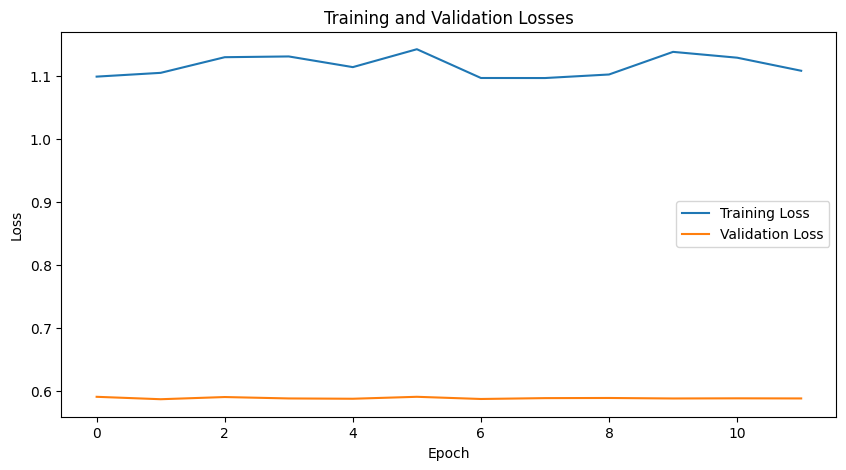

In [ ]:
import optuna
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

def objective(trial):
    n_hidden = trial.suggest_int('n_hidden', 6, 9)
    n_neurons = trial.suggest_int('n_neurons', 32, 256)
    activation = trial.suggest_categorical('activation', ['relu', 'tanh', 'sigmoid', 'leaky_relu'])
    include_dropout = trial.suggest_categorical('include_dropout', [True, False])

    # Build the model
    build = build_model(n_hidden=n_hidden,
                        n_neurons=n_neurons,
                        activation=activation,
                        input_dim=15,  # Adjust as necessary
                        output_dim=1,
                        include_dropout=include_dropout)

    optimizer = optim.Adam(build.parameters(), lr=0.001, weight_decay=0.0005)
    C = nn.MSELoss()

    training_losses, validation_losses, _ = train_model(build, train_loader, val_loader, C, optimizer, num_epochs=500, patience=10)

    # Store intermediate results to access later if needed
    trial.set_user_attr('training_losses', training_losses)
    trial.set_user_attr('validation_losses', validation_losses)

    return min(validation_losses)

# Create a study and optimize it
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

# Get the best trial
best_trial = study.best_trial
best_training_losses = best_trial.user_attrs['training_losses']
best_validation_losses = best_trial.user_attrs['validation_losses']

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(best_training_losses, label='Training Loss')
plt.plot(best_validation_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()

# GAMs

In [ ]:
!pip uninstall -y pygam
!pip install numpy==2.0.2 scipy==1.14.1
!pip install git+https://github.com/dswah/pyGAM.git --quiet

Found existing installation: pygam 0.9.1
Uninstalling pygam-0.9.1:
  Successfully uninstalled pygam-0.9.1
  Using cached numpy-2.0.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (60 kB)
  Using cached scipy-1.14.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (60 kB)
Using cached numpy-2.0.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (19.5 MB)
Using cached scipy-1.14.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (41.2 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
  Attempting uninstall: scipy
    Found existing installation: scipy 1.11.4
    Uninstalling scipy-1.11.4:
      Successfully uninstalled scipy-1.11.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 re

100% (11 of 11) |########################| Elapsed Time: 0:00:12 Time:  0:00:12


Validation MSE: 1.4608
Validation R^2: -1.5550


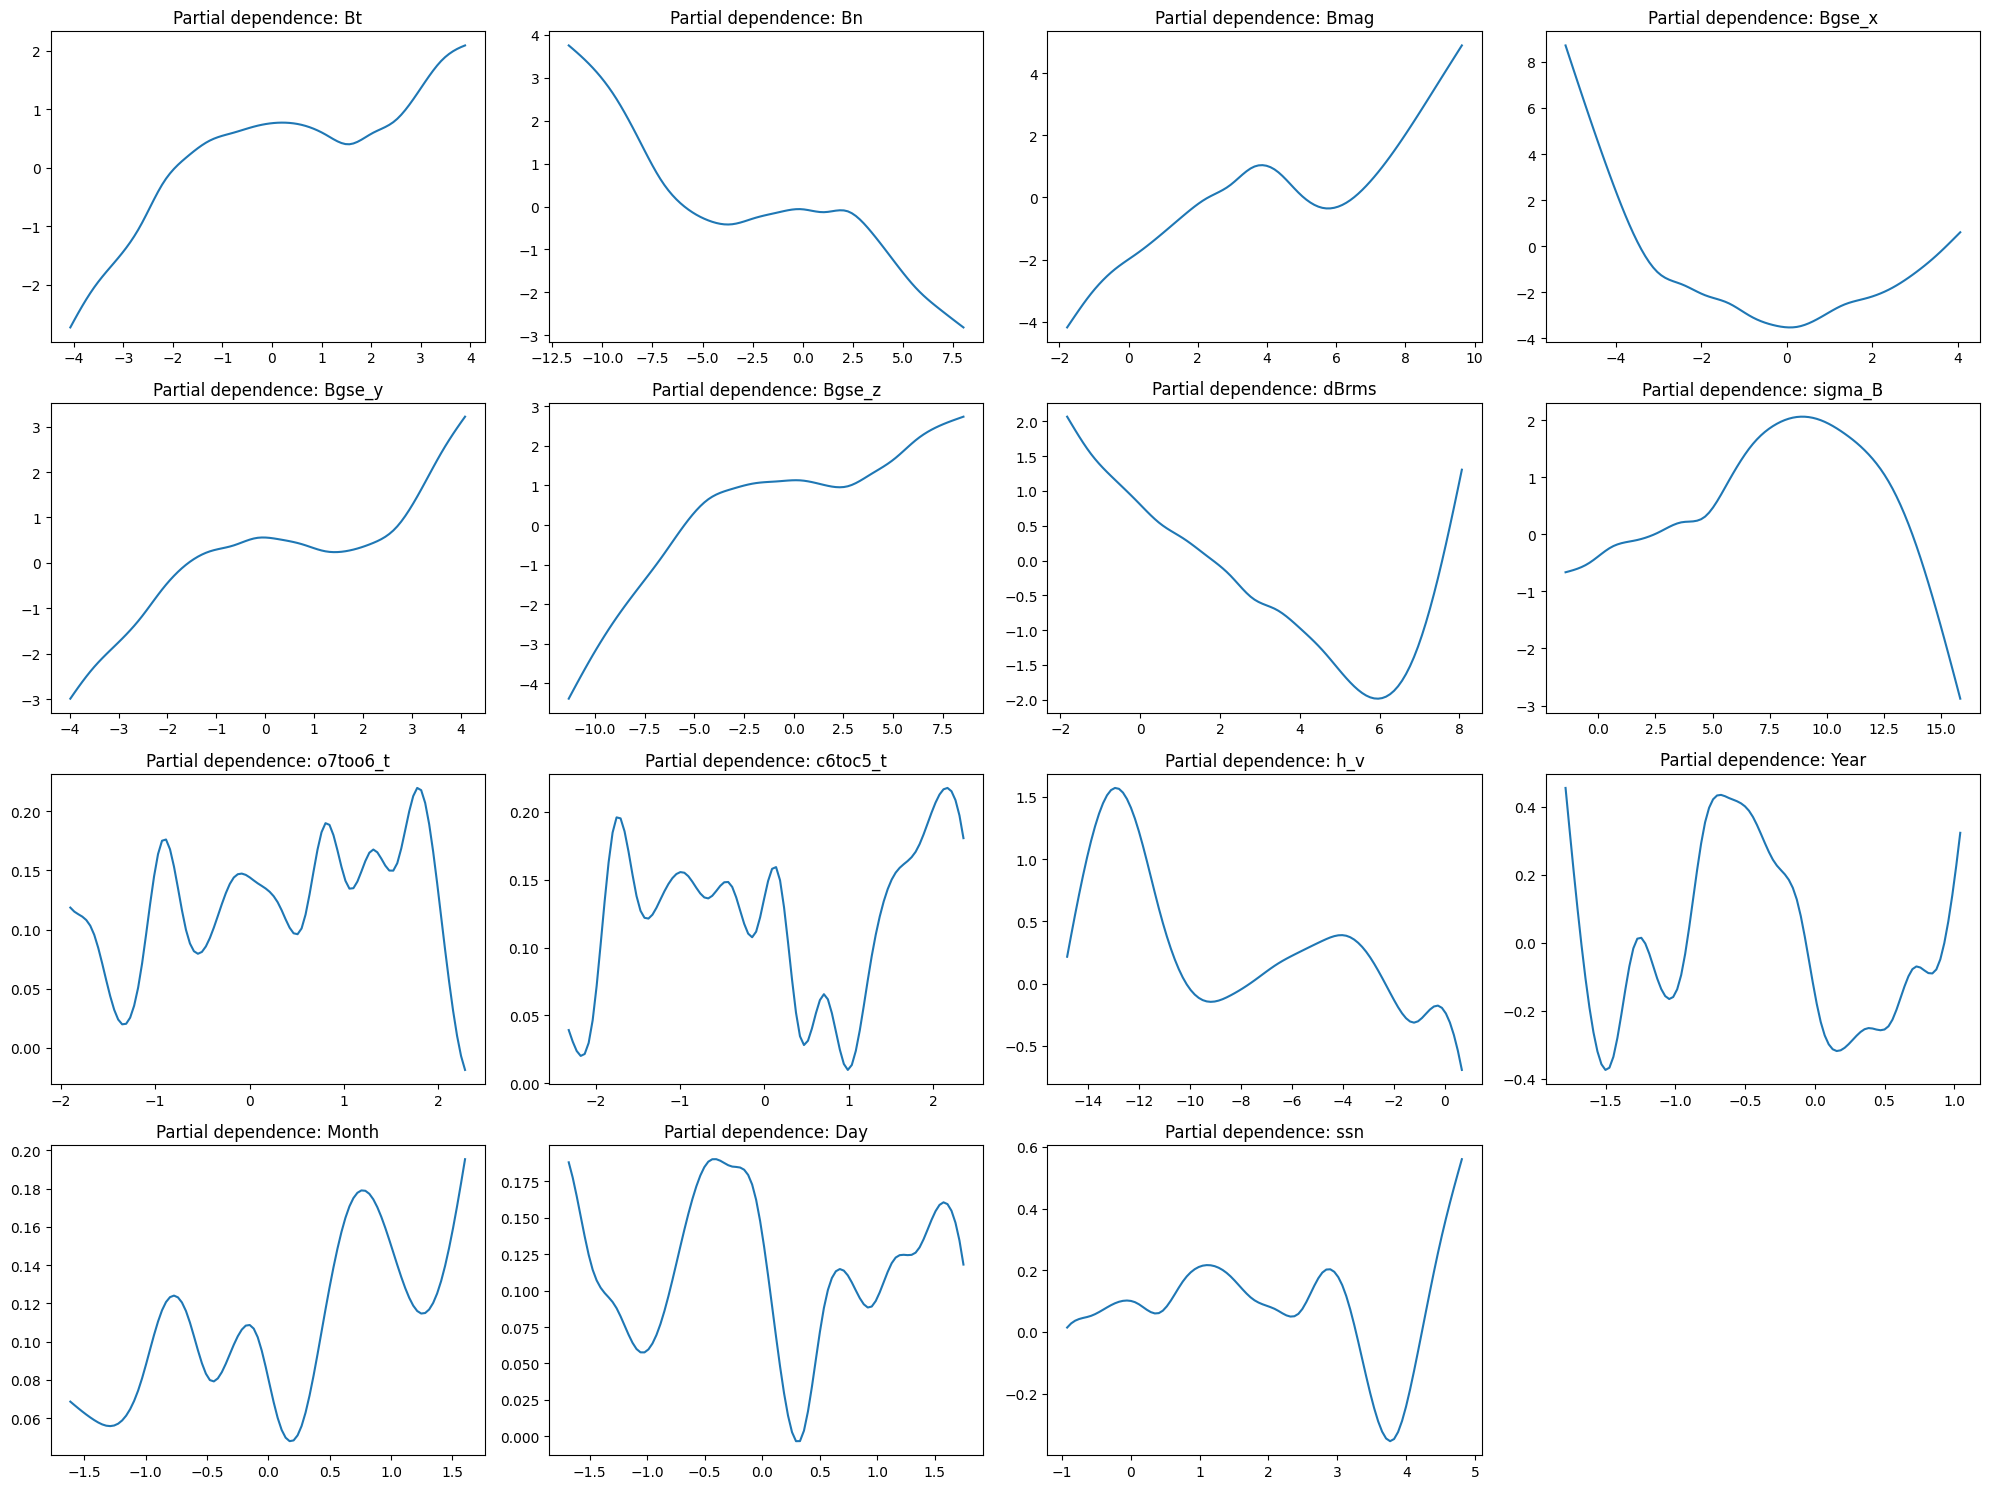

In [ ]:
from pygam import LinearGAM, s
from scipy.sparse import issparse

# Fit a GAM with a spline term for each feature
gam = LinearGAM(s(0) + s(1) + s(2) + s(3) + s(4) + s(5) +
                s(6) + s(7) + s(8) + s(9) + s(10) +
                s(11) + s(12) + s(13) + s(14))

X_train_dense = X_train.values
if issparse(X_train_dense):
    X_train_dense = X_train_dense.toarray()

y_train_array = y_train

gam.gridsearch(X_train_dense, y_train_array)

# Predictions
y_pred = gam.predict(X_val)

# Evaluation
mse = mean_squared_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

print(f"Validation MSE: {mse:.4f}")
print(f"Validation R^2: {r2:.4f}")

plt.figure(figsize=(20, 15))
for i, term in enumerate(gam.terms):
    if term.isintercept:
        continue
    plt.subplot(4, 4, i + 1)  # Add 1 to i to start subplot indexing at 1
    XX = gam.generate_X_grid(term=i)
    plt.plot(XX[:, i], gam.partial_dependence(term=i, X=XX))
    plt.title(f'Partial dependence: {feature_cols[i]}')
plt.tight_layout()
plt.show()